### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

In [4]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(coords) = compute_energy(coords..., m.P[1], m.P[2])

In [5]:
# カスタムレイヤでポテンシャルエネルギー値を計算できるかテスト
m = Energy([1.0, 1.0])
coords = ([0.0, 0.0, 0.0], [2.0, 0.0, 0.0])
m(coords)

-0.031005859375

### MCMCの定義

In [6]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-2)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

next_coords (generic function with 2 methods)

In [7]:
#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        delta_U = compute_energy(next_coords1, next_coords2, epsilon, sigma) - compute_energy(coords1, coords2, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha >= rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    return coords1_trj, coords2_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### 訓練データの作成

In [8]:
epsilon_true = 1.0
sigma_true = 2.0

#kB = 1.380649e-23 #ボルツマン定数
kBT = 2.0
beta = 1.0/(kBT)

seed_value = 123 #乱数固定
Random.seed!(seed_value)

X_train = []
y_train = []
coords = ([0.0, 0.0, 0.0], [2.1, 0.0, 0.0]) #初期座標
nstep = 10000

coords1_trj, coords2_trj, alpha = mcmc(coords[1], coords[2], epsilon_true, sigma_true, nstep, beta)

(Any[[0.6380024692036705, -0.4304320698824834, 0.4729885745903382], [0.00021213795535383052, 0.0008680675745334843, 0.003908786980927811], [0.0045456708281254804, 0.001673667393278896, 0.002181165773490647], [0.0031721640923099044, -0.0023042865418335095, 0.004382191368393943], [0.008006521203508303, 0.0015046883663245554, 0.0017223594261344928], [0.0076426186467574465, 0.0036410475911866345, -0.0012183914789984079], [0.004687916819961041, 0.0025079492202761708, -0.006032671483099023], [0.0034617494142885775, 0.006263499215872357, -0.008386990079479717], [0.004337598776377088, 0.009357826775286977, -0.011148582052274435], [0.0064022101920579895, 0.011317703683387272, -0.007358812632897362]  …  [0.6214756975224085, -0.4160235719133763, 0.4654911186283864], [0.6200099643694188, -0.414189185848063, 0.4696647937984554], [0.6166780704184155, -0.4188537374239787, 0.4713992880610582], [0.6143051362839316, -0.41953714957200544, 0.4743217238325625], [0.618550323098886, -0.42018610257591466, 0.4

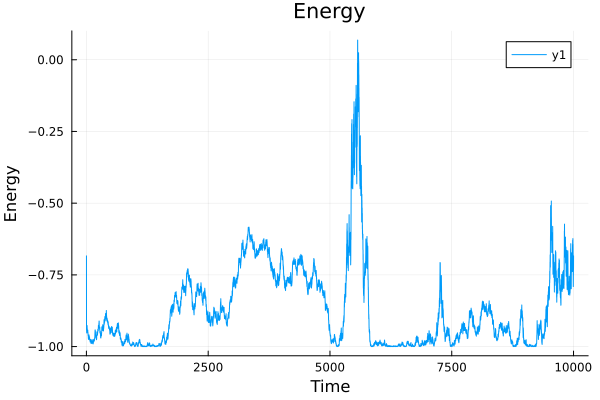

In [9]:
X_train = collect(zip(coords1_trj, coords2_trj))
y_train = map(x -> compute_energy(x[1], x[2], epsilon_true, sigma_true), X_train)
plot(y_train[1:end],title="Energy",
    xlabel="Time", ylabel="Energy")

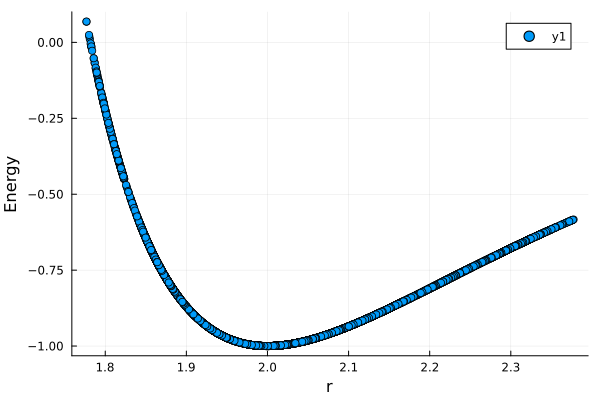

In [10]:
r = [sqrt(sum((x - y).^2)) for (x, y) in X_train]
scatter(r[1:end], y_train[1:end],
    ylabel="Energy",xlabel="r")

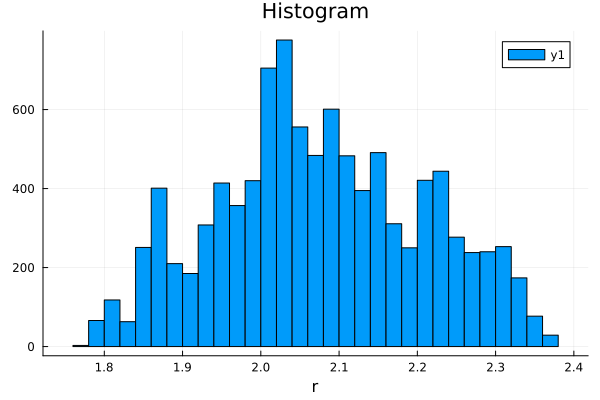

In [11]:
histogram(r[1:end],title="Histogram",
        xlabel="r")

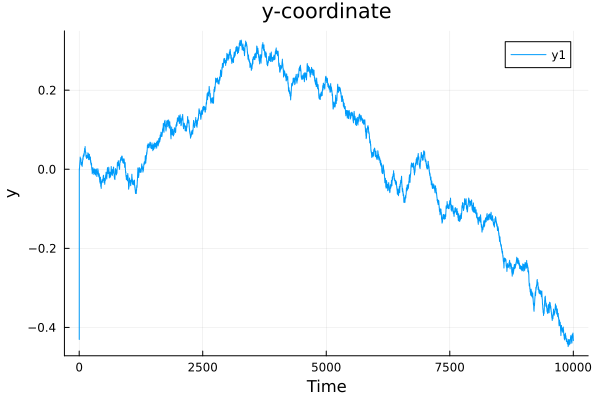

In [12]:
plot([x[2] for x in coords1_trj],
    title="y-coordinate",
    xlabel="Time", ylabel="y")

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [13]:
# Lossの定義
m = Energy([0.1, 0.1])
loss(X, y) = Flux.Losses.mse(mean(m.(X)), mean(y))
loss(X_train, y_train)

0.7517880601433022

In [14]:
m(X_train[1])

-4.882571643283338e-9

In [15]:
# DataやOptimizerの定義
train_loader = Flux.Data.DataLoader((data=X_train, label=y_train), batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-3) #学習率を少しだけ小さくした

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [16]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [17]:
# 訓練
loss_train = []

for epoch in 1:20
    for (X, y) in train_loader
        gs = gradient(() -> loss(X, y), ps)
        Flux.Optimise.update!(opt, ps, gs)
    end
    push!(loss_train, loss(X_train, y_train))
    if epoch%2 == 1
        print_callback(epoch, loss(X_train, y_train), ps)
    end
end

Epoch: 1, loss: 4.793365853849891e-6
param: [1.688053440349289, 1.6874125780388691]


Epoch: 3, loss: 1.7003286266255164e-6
param: [1.6128801248245614, 1.7026291097573898]


Epoch: 5, loss: 0.0005164530058211915
param: [1.518746110961204, 1.7158422586772835]


Epoch: 7, loss: 3.268167031613353e-6
param: [1.4266551062040138, 1.7520271457069123]


Epoch: 9, loss: 3.114389137923262e-7
param: [1.302449239333686, 1.790419048238111]


Epoch: 11, loss: 2.0077547024003952e-5
param: [1.1367616349569394, 1.8643146764608052]


Epoch: 13, loss: 2.5029523020046717e-13
param: [1.0000002460239674, 1.9999901775240974]


Epoch: 15, loss: 0.0
param: [0.9999999999999999, 1.9999999999999991]


Epoch: 17, loss: 0.0
param: [1.0, 2.0]


Epoch: 19, loss: 0.0
param: [1.0, 2.0]


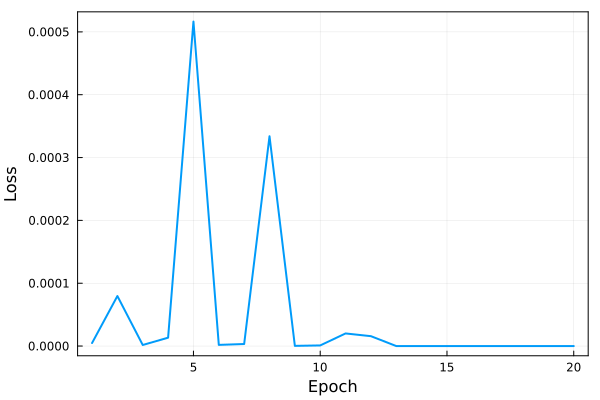

In [18]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [19]:
println("Ground-truth epsilon: ", epsilon_true)
println("Estimate epsilon:     ", m.P[1])

println("Ground-truth sigma: ", sigma_true)
println("Estimate sigma:     ", m.P[2])

Ground-truth epsilon: 1.0
Estimate epsilon:     1.0
Ground-truth sigma: 2.0
Estimate sigma:     2.0
